In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc

## Classification

Given: $Data = ((x_1,y_1),(x_2,y_2),...,(x_n,y_n)), x \in R^d y\in \{0,1,2,..,m\}$

In a Classification task the dependent (response) variable is a qualitative(i.e. Categorical) variable. The independent variable(s) (predictors, explanatory, features) can be numerical and/or categorical.

#### Goal

The goal of a classification task is to predict the category (i.e. class) of the dependent variable of an observation given the features in the observation.

Some classification methods first predict the probability that observation belongs to a category then use a threshold to classify the sample.

#### Types of Classification Methods:

There are many classification methods, we will study:
    
* Logistic Regression: The response belongs to one of two categories
* Multinomial Regression: Response belongs to three or more categories
* Neural Networks: Multilayered Perceptrons implementing Logistic or Multinomial Regression
* K-Nearest Neighbor(KNN): Non-parametric lazy learning algorithm (i.e. just uses the data)
* Naive Bayes: A generative model which assumes the features are independent
* Linear Discriminant Analysis (LDA): A generative model assuming Normality of classes
* Support Vector Machines: Linear and non-linear classifier which separates the data with a hyperplane
* Tree and ensemble methods: Bagging, Random Forests and Boosting

### Default data set

Goal: Predict if a person will default on his/her credit card based on income and credit card balance

In [4]:
default = pd.read_csv('Default1.csv')
default.tail()

,default,student,balance,income
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,NaN
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365
9999,No,Yes,200.922183,16862.952321


#### Exploratory Data Analysis

##### Check for Missing Values

In [5]:
np.sum(default.isna())

default    0
student    0
balance    0
income     7
dtype: int64

##### Impute missing values

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Which stategy to use??

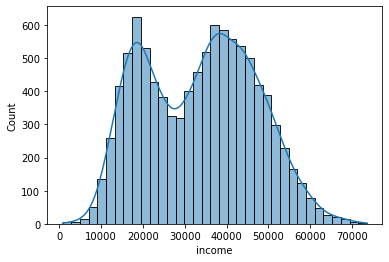

In [6]:
sns.histplot(default.income,kde=True);

In [7]:
im = SimpleImputer(strategy = 'median')
default.income = im.fit_transform(default.income.values.reshape(-1,1))
np.sum(default.isna())

default    0
student    0
balance    0
income     0
dtype: int64

In [8]:
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,34555.826973
4,No,No,785.655883,38463.495879


In [9]:
default.corr()

,balance,income
balance,1.00000,-0.15245
income,-0.15245,1.00000


In [10]:
default.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33520.521411
std,483.714985,13333.453226
min,0.000000,771.967729
25%,481.731105,21346.130845
50%,823.636973,34555.826973
75%,1166.308386,43803.775191
max,2654.322576,73554.233495


In [11]:
default.groupby('default').mean()

,balance,income
default,,
No,803.94375,33569.828087
Yes,1747.82169,32089.147124


In [12]:
default.groupby('student').mean()

,balance,income
student,,
No,771.770402,40012.537071
Yes,987.818239,17960.853444


Students have higher balances and lower income than non-students

#### Seaborn pairplots

https://seaborn.pydata.org/generated/seaborn.pairplot.html

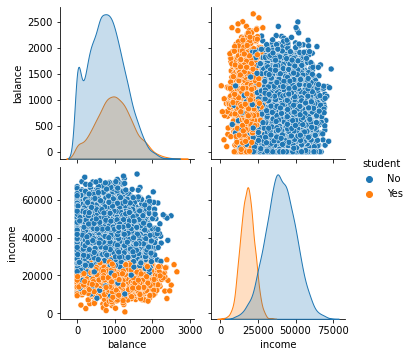

In [13]:
sns.pairplot(default, hue='student', diag_kind='kde');

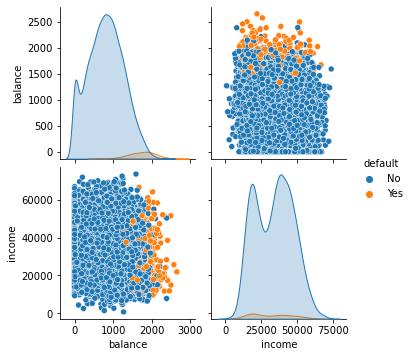

In [14]:
sns.pairplot(default, hue='default', diag_kind='kde');

The dataset is unbalanced with many more not defaulters than defaulters.

Looks like a bimodal distribution of income.

From the plot it seems that there are observations with a zero balance.  What do zeros mean in this case?

In [15]:
np.sum(default.balance == 0)

499

##### Visualize Descriptive Statistics

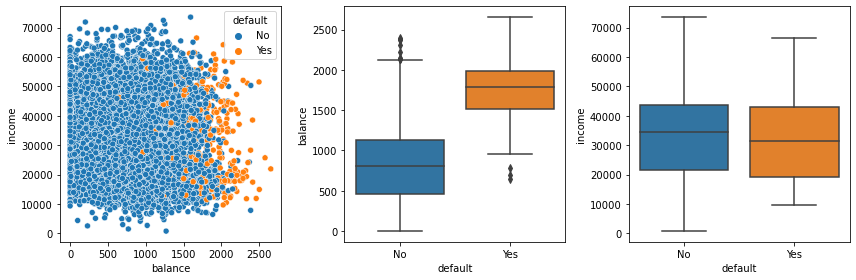

In [17]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (12,4))
sns.scatterplot(x='balance',y='income',hue='default',data=default,ax=ax1)
sns.boxplot(x='default',y='balance',data=default,ax=ax2)
sns.boxplot(x='default',y='income',data=default,ax=ax3)
plt.tight_layout()

Balance appears to be a better predictor than income

### Why Not Linear Regression

Why can't we use linear regression for classification?

Two reasons:
* The response variable is not normally distributed
* The regression doesn't map to (0,1)


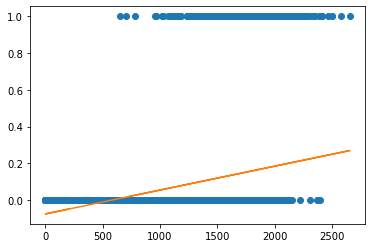

In [18]:
X = default.loc[:, 'balance'].values.reshape(-1,1)
y =  LabelEncoder().fit_transform(default.default)

Model = LinearRegression()
Model.fit(X, y)

plt.plot(X,y,'o')
plt.plot(X,Model.predict(X));

### Logistic Regression

Logistic Regression is a classification algorithm. It directly models the probability that the response Y belongs to a particular category. The probability is then used to assign a class to the response.

It produces a non-linear response via the Logistic function Also known as the sigmoid function due to its sigmoidal shape. The function asymptotes at 0 and 1.

The Logistic function maps $(-\infty,+\infty) -> (0,1)$

<div style="font-size: 125%;">
$$logistic(z) = \sigma(z) = \frac{e^z} {1+e^z} = \frac{1}{1 + e^{-z}}$$
</div>

The derivative of the Logistic function is: 

<div style="font-size: 115%;">
$$ \frac{d}{dz}\sigma(z) = -(1 + e^{-z})^{-2}(-e^{-z}) =  \frac{1}{1 + e^{-z}}\left(1 - \frac{1}{1 + e^{-z}}\right) =  \sigma(z)(1 - \sigma(z))$$
</div>

In [19]:
def logistic(z):
    return 1/(1+np.exp(-z))
# Derivative of Sigmoid or Logistic function
def D_logistic(z): 
    s = logistic(z)
    return s * (1 - s)

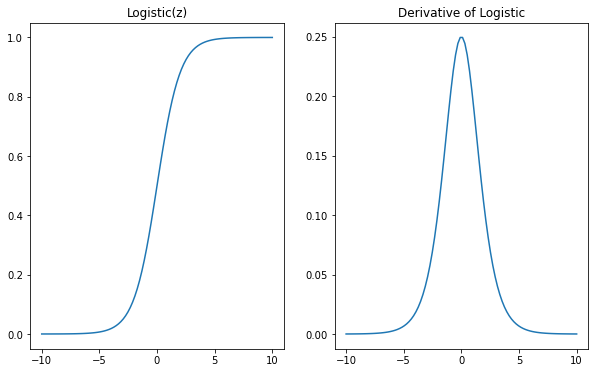

In [20]:
z = np.linspace(-10,10,100)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
ax1.plot(z,logistic(z))
ax1.set_title('Logistic(z)')
ax2.plot(z,D_logistic(z))
ax2.set_title('Derivative of Logistic');

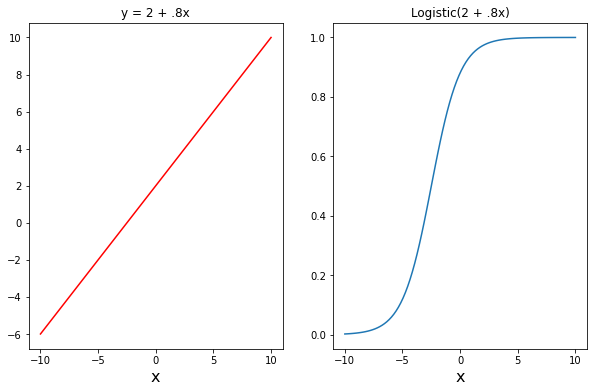

In [21]:
x = np.linspace(-10, 10, 100)
y = 2 + .8*x
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
ax1.plot(x,y,'r')
ax1.set_title("y = 2 + .8x")
ax1.set_xlabel('x', fontsize=16)
ax2.plot(x, logistic(y))
ax2.set_title("Logistic(2 + .8x)")
ax2.set_xlabel('x', fontsize=16);

 
### Logistic Model

Given Data (assume independent and identically distributed (iid)): 

<div style="font-size: 115%;"> $\{(x_1,y_1),(x_2,y_2),...,(x_n,y_n)\}$, $x_i \in R^d$, $y_i \in \{0,1\}$ </div>



<div style="font-size: 125%;">

$$ Y \sim Bernoulli(p(X))$$
$$ p(X) = P(Y = 1)|X) = logistic(\beta_0 + \beta_1X) = \frac{e^{\beta_0 + \beta_1X}} {1+e^{\beta_0 + \beta_1X}} = \frac{1}{1 + e^{-(\beta_0 + \beta_1X)}}$$
</div>

 

### Estimating the coefficients

####  Maximum Likelihood  Estimate

We want to estimate the coefficients such that when plugged into p(x), we get a number close to 1 for those individuals who defaulted and close to 0 for those who didn't.

To do this we maximize the likelihood function L($\beta_0$,$\beta_1$;x) where $p(x) = logistic(\beta_0 + \beta_1x)$


<div style="font-size: 125%;"> 
$$\hat{\theta} = \underset{\theta}{\mathrm{argmax}}L(\theta | x,y)$$

$$\hat{\theta} = (\hat{\beta}_0, \hat{\beta}_1) =  \underset{(\beta_0,\beta_1)}{\mathrm{argmax}}L(\beta_0,\beta_1 | x,y)$$
</div>

Since the observations are independent and y is a Bernoulli random variable, i.e. $P(Y=k;p)=p^k(1-p^{1-k})$

<div style="font-size: 125%;"> 
$$L(\beta_0,\beta_1;y_i,x_i) = \Pi_{i:y_i=1}p(x_i)^{y_i}\Pi_{j:y_j=0}(1 - p(x_j))^{1-y_i} $$
</div>

#### Log Likelihood

If had Y~Bernoulli(.7) with 50 observations, 30 successes and 20 failures, then the Likelihood is very close to 0 which can cause underflow.

In [22]:
(.7**30)*(.3**20)

7.858982013441637e-16

Since the Likelihood involves many multiplications, we maximize the log of the likelihood called the Log Likelihood.

We do this because multiplying many numbers x,  $0 \lt x \lt 1$, can cause underflow as seen above.

The Log function turns multiplication into addition. It is a monotonically increasing function so it has the same maximum (or minimum) as the function. 

In this case, the optimization is actually minimizing the negative Log

<div style="font-size: 125%;"> 
$$ LogL(\beta_0,\beta_1) = \sum[{-log(1 + e^{\beta_0 + \beta_1X})} + y_i(\beta_0 + \beta_1X)]$$
</div>

No closed from solution of the optimization, since the non-linearity of the logistic function (Recall: In Linear Regression there was a closed form solution i.e. the Normal equation)

The software uses some numerical iterative process (e.g. Newton's Method). Unfortunately this may not converge because: 
- there are too many predictors for number of observations,
- the predictors too highly correlated and/or
- there is complete separation of the classes.
    

### Sklearn logistic Regression

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### Solvers
* Default: liblinear
* Stochastic Gradient Descent
* Newton's Method

#### Multi_class
* Default: ovr - one versus rest, trains a single classifier per class (using the logistic)
* Multinomial - uses softmax

### Single Predictor Logistic Regression

* Dependent variable: default
* Independent variable: balance

#### Transform variables to arrays


In [23]:
X = default.loc[:, 'balance'].values.reshape(-1,1) #2-d array
y =  LabelEncoder().fit_transform(default.default)
X.shape,y.shape

((10000, 1), (10000,))

In [24]:
y[0:5]

array([0, 0, 0, 0, 0])

#### Split the data

Since y is a categorical variable, we use the stratify keyword to maintain the proportion of categories.


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1), (2000, 1), (8000,), (2000,))

#### Create the model and fit to the training data

In [26]:
# Fitting Logistic Regression on default as a function of balance

model = LogisticRegression(random_state = 42)
model.fit(X_train, y_train)


LogisticRegression(random_state=42)

#### Predict new data point

In [27]:
# Prediction
x_new = 1000.0
X_pred = np.array((x_new)).reshape(1,1)
y_pred = model.predict(X_pred)
print(f'Prediction for Balance = {x_new} is Default = {y_pred[0]}')

Prediction for Balance = 1000.0 is Default = 0


### Interpreting the Coefficients
 

#### Logit ( Log odds)

<div style="font-size: 115%;">
$$Odds = \frac{P(Win)}{P(Not Win)}$$
</div>

**Odds** are the probability of winning divided by probability of not winning.

If probability of winning is .8,Odds = .8/(1 - .8) = 4. The is 4 to 1 odds which means you will win 4 times out of 5.
    
The Logit function is the natural log of the odds that the response Y equals one of the categories. Logit is the inverse of the logistic function.

<div style="font-size: 125%;">
$$logit(p) =  log\big(\frac{p}{1-p}\big)$$
</div>

A logistic model is one where the log-odds of the probability of an event is a linear combination of independent predictor variables.

    
Substitute for P(X) from above:

<div style="font-size: 125%;">
$$\frac{p(X)}{1 - p(X)} = \frac{\frac{e^{\beta_0 + \beta_1}} {1+e^{\beta_0 + \beta_1}}} {1 - \frac{e^{\beta_0 + \beta_1}} {1+e^{\beta_0 + \beta_1}}}
= \frac{\frac{e^{\beta_0 + \beta_1X}} {1+e^{\beta_0 + \beta_1X}}} {\frac{1+e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}} - \frac{e^{\beta_0 + \beta_1X}} {1+e^{\beta_0 + \beta_1X}}}={e^{\beta_0 + \beta_1X}}$$
</div>

Log odds: Take log of both sides:

<div style="font-size: 125%;"> 
$$log\big(\frac{p(X)}{1 - p(X)}\big) = log(e^{\beta_0 + \beta_1X}) = \beta_0 + \beta_1 X$$
</div>

#### Extract Coefficients

In [28]:
print(f'Intercept: {np.round(model.intercept_[0],3)}, Coefficient: {np.round(model.coef_[0,0],4)}')

Intercept: -10.682, Coefficient: 0.0055


#### One unit increase in balance results in an increase in the log odds of default by 0.0055 units

#### To convert to probability, need to apply the logistic to $\beta_0 + \beta_1*x$

$$P(Y = yes | X = 1000) = logistic( \beta_0 + \beta_1 * X)$$

In [29]:
# Class yes is encoded as a one
z = model.intercept_[0] + model.coef_[0,0] * x_new
print(f"Probability Y = yes for X = 1000: {np.round(logistic(z),4)}")

Probability Y = yes for X = 1000: 0.0058


#### Prediction probabilities from sklearn

In [30]:
y_prob = model.predict_proba(X_pred)
print(f'Prediction Probabilities [no,yes] = {y_prob}')

Prediction Probabilities [no,yes] = [[0.9942235 0.0057765]]


### Model Accuracy

#### Confusion Matrix

https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/

| |Predicted 0|Predicted 1|
|-----:|-----:|:----
|Actual 0  |TN | FP   | 
|Actual 1  |FN  | TP   | 


In [31]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix for Test Data:")
print(cm)

Confusion Matrix for Test Data:
[[1925    8]
 [  47   20]]


#### Accuracy: tp+tn/(tp+tn+fp+fn)

Accuracy is the probability of correct classification

In [32]:
def accuracy(cm):
    return np.trace(cm)/np.sum(cm)

accuracy(cm)

model.score(X_test,y_test)

0.9725

#### Error Rate (aka Misclassification Rate) fp+fn/(tp+tn+fp+fn)

The error rate is the probability of misclassification, i.e. 1 - accuracy(cm).



In [33]:
def error_rate(cm):
    return (cm[0,1]+cm[1,0])/np.sum(cm)
error_rate(cm)

0.0275

#### Precision: tp/(tp+fp)

Precision is the ability of the model not mislabel a true positive. 

It minimizes false positives, i.e. if you don't have COVID-19 minimizes the test being positive.

It calculates how often is the model correct when it predicts a positive response.

In [34]:
def precision(cm):
    return cm[1,1]/(cm[1,1]+cm[0,1])
precision(cm)

0.7142857142857143

#### Recall: tp/(tp+fn)

Recall is the ability of the model to find all positive cases.

If subject has COVID-19 you want a high probability that the test is positive.

When the response is actually positive, how often does the model predict positive.

In [35]:
def recall(cm):
    return cm[1,1]/(cm[1,1] + cm[1,0])
recall(cm)

0.29850746268656714

#### $F_1$ score (also called the F-score)

F_1 is the Harmonic mean of precision and recall. The Harmonic mean is used to average rates.

$$F_1 = \frac{2}{recall^{-1} + precision^{-1}} = \frac{tp}{tp+\frac{1}{2}(fp+fn)}$$

In [36]:
def F1(cm):
    tp,fp,fn = cm[1,1],cm[0,1],cm[1,0]
    return tp/(tp + 1/2*(fp+fn))
F1(cm)

0.42105263157894735

#### Receiver Operating Characteristic Curve (ROC) and Area Under Curve (ROC)

The ROC is a visualization of the performance of a classification model. 

It depicts the trade-off between the true positive rate (tpr) and false positive rate (fpr) at different probability thresholds.

Let tpr = recall, fpr = probability of a false alarm, then

<div style="font-size: 115%;">
$$ tpr = \frac{tp}{tp+fn} \\
   fpr = \frac{fp}{fp+tn} $$
</div>

The Area Under the Curve(AUC) represents the area under the ROC. It is a quantitative indicator of performance:

- Excellent: .9 <= AUC <= 1.0
- Good: .8 <= AUC < 9.0
- Fair: .7 <= AUC < 8.0
- Poor: .6 <= AUC < 7.0
- Fail: .5 <= AUC < 6.0

In [37]:
y_pred_probs = model.predict_proba(X_test) # prediction probability for each obsevation
print(y_pred_probs.shape)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,1]) # For binary classification only
print(thresholds.shape)
roc_auc = auc(fpr, tpr)

(2000, 2)
(93,)


In [38]:
np.sum(y_pred_probs[0,:])

1.0

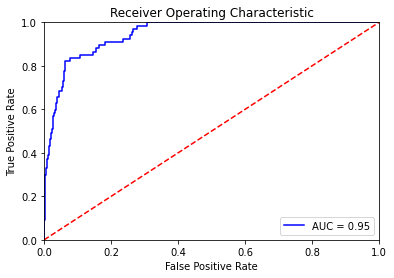

In [39]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

The upper left corner (0,1) of the ROC graph represents no false negatives (100% sensitivity) and no false positives (100% specificity). 

A random guess would give a point along the dotted red diagonal line. 

### Single qualitative predictor


In [40]:
X = default.loc[:,['student']].values.reshape(-1,1)   
y = default.loc[:,'default'].values
labelencoder = LabelEncoder()
X[:,0] = labelencoder.fit_transform(X[:,0])
y =  LabelEncoder().fit_transform(default.default)
X[0:5,:],y[0:5]

(array([[0],
        [1],
        [0],
        [0],
        [0]], dtype=object),
 array([0, 0, 0, 0, 0]))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y,random_state = 1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 1), (2500, 1), (7500,), (2500,))

In [42]:
model = LogisticRegression(solver='liblinear',class_weight='balanced')
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)
print(f'Mean Probabilities: {np.round(np.mean(y_probs[:,0]),3)},{np.round(np.mean(y_probs[:,1]),3)}')

print(f'Intercept: {np.round(model.intercept_[0],3)}, Coefficients: {np.round(model.coef_,4)[0]}')

print(f'Model Score: {model.score(X_test,y_test)}')

y_preds = model.predict(X_test)
cm=confusion_matrix(y_test,y_preds)
print(f'Confusion Matrix \n{cm}')
print('Accuracy: ',accuracy(cm))

Mean Probabilities: 0.506,0.494
Intercept: -0.151, Coefficients: [0.4416]
Model Score: 0.7008
Confusion Matrix 
[[1723  694]
 [  54   29]]
Accuracy:  0.7008


### Multiple Logistic Regression

<div style="font-size: 125%;">

$$p(X) = Pr(Y = 1|X) = \frac{e^{\beta_0 + \beta_1X_1+...+\beta_pX_p}} {1+e^{\beta_0 + \beta_1X_1+...+\beta_pX_p}}$$

$$log\left(\frac{p(X)}{1 - p(X)}\right) = \beta_0 + \beta_1X_1+...+\beta_pX_p$$

</div>

#### Independent Variables: student,balance, income

In [43]:
X = default.iloc[:,1:].values.reshape(-1,3)   
y = default.loc[:,'default']
labelencoder = LabelEncoder()
X[:,0] = labelencoder.fit_transform(X[:,0]) # Encode student
X[0:5,:]

array([[0, 729.526495207286, 44361.6250742669],
       [1, 817.180406555498, 12106.1347003149],
       [0, 1073.54916401173, 31767.1389473999],
       [0, 529.250604745278, 34555.8269729204],
       [0, 785.655882930501, 38463.4958787229]], dtype=object)

#### Classification so stratify response variable

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,random_state = 1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 3), (2000, 3), (8000,), (2000,))

#### Standardize numerical variables

In [45]:
sc = StandardScaler()
X_train[:,1:] = sc.fit_transform(X_train[:,1:])
X_test[:,1:] = sc.transform(X_test[:,1:])

X_train[0:5,:]

array([[0, -1.1531017801959138, 0.44205883944080054],
       [1, -0.23008110741966023, -1.312832747265214],
       [0, -0.10098883261103411, 0.9418325679748714],
       [0, 0.273265812401122, -0.4924486151257196],
       [0, -1.7401883080220872, -0.5865588973985897]], dtype=object)

#### Fit Model

In [46]:
model = LogisticRegression(random_state = 12)
model.fit(X_train, y_train)

LogisticRegression(random_state=12)

#### Predict test data and output confusion matrix

In [47]:
y_preds = model.predict(X_test)
cm = confusion_matrix(y_test,y_preds)
print("Confusion Matrix for Test Data:")
print(cm)
print(f'Accuracy: {accuracy(cm)}')

Confusion Matrix for Test Data:
[[1926    7]
 [  45   22]]
Accuracy: 0.974


#### Print Intercept and Coefficients

In [48]:
coefs = np.round(model.coef_,4)[0]
print(f'Intercept: {np.round(model.intercept_[0],3)}\nCoefficients:\nstudent {coefs[0]}\nbalance {coefs[1]}\nincome {coefs[2]}')

Intercept: -5.922
Coefficients:
student -0.3954
balance 2.688
income 0.0965


 ####  Confounding

 
Confounding is when the results obtained using 1 predictor may be different than results obtained with multiple predictors, especially if there are correlations among predictors.

The coefficient for student above is negative but the coefficient was positive in the the single predictor model.
The negative coefficient indicates that a student is less likely to default than a non-student, positive indicates more likely.

 

### Multinomial (Softmax) Regression

When the dependent variable has 3 or more classes we use the softmax function rather than logistic.

The Softmax function inputs a vector and outputs the probability that each element of the input belongs to a particular class: For a vector $\mu$ with length k:

<div style="font-size: 125%;">
$$ softmax(\mu_i) = \sum_{k}{\frac{e^{\mu_i}}{e^{\mu_k}}}$$
</div>

The softmax of each value in $\mu$ sums up to 1( i.e. softmax($\mu_0$)+softmax($\mu_1$)+...+ softmax($\mu_k$) = 1). The softmax function is reduced to the logistic function when k=2.

The Categorical distribution is the likelihood distribution rather than the Bernoulli distribution. The categorical distribution is the generalization of the Bernoulli to more than two outcomes. The categorical (single roll of a die) is a special case of the multinomial distribution (N rolls of a die). 

In [49]:
z  = np.array([1.5,3.2,.75] )

def Softmax(z):
    ez = np.e**z
    return ez/np.sum(ez)
s = Softmax(z)
print(f'Softmax(z) = {s}, sum: {np.sum(s)}')   


Softmax(z) = [0.14396124 0.78803628 0.06800248], sum: 1.0


In [50]:
from sklearn.utils.extmath import softmax
x = z.reshape(1,-1)
s = softmax(x)
print(f'Softmax(z) = {s}, sum: {np.sum(s)}')   

Softmax(z) = [[0.14396124 0.78803628 0.06800248]], sum: 0.9999999999999998


#### Data

In the full Iris dataset, the species variable has three classes: setosa,versicolor,virginica.


We will center the feature matrix containing the full set of features: sepal length and width, petal length and width.

In [51]:
iris = sns.load_dataset('iris')
iris.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


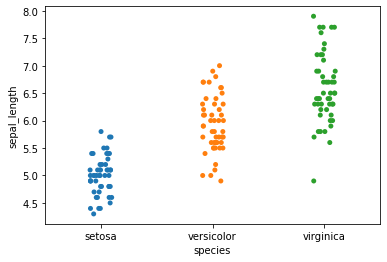

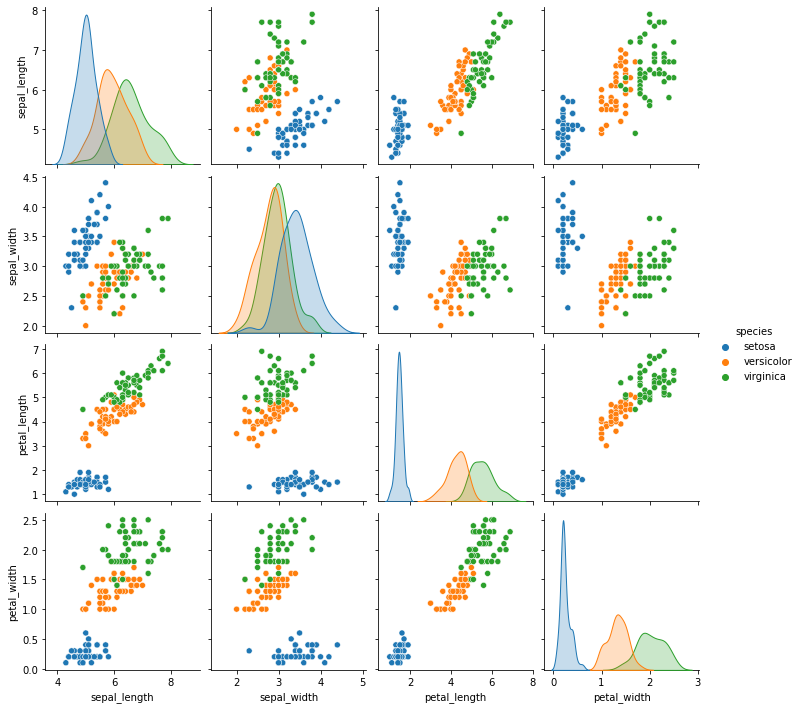

In [52]:
sns.stripplot(x="species", y="sepal_length", data=iris) #jitter=True
sns.pairplot(iris, hue='species', diag_kind='kde');

In [53]:
# Convert to arrays

X = iris.iloc[:, 0:4].values.reshape(-1,4)
y = iris.iloc[:, 4].values
X.shape, y[0:5]

((150, 4),
 array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa'], dtype=object))

In [54]:
# Split the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,random_state=1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

#### Fit model using defaults


In [55]:
# Fit Logistic Regression to the Training set

model = LogisticRegression(random_state = 1234)
model.fit(X_train, y_train)
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1234,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [56]:
# Predict the Test set results
y_pred = model.predict(X_test)

# Make the Confusion Matrix and calculate the accuracy
cm = confusion_matrix(y_test, y_pred)
print('Model Classes: ', model.classes_)
print("Confusion Matrix for Test Data:")
print(cm)
print(f'Accuracy: {accuracy(cm)}')

Model Classes:  ['setosa' 'versicolor' 'virginica']
Confusion Matrix for Test Data:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
Accuracy: 0.9333333333333333


In [57]:
print('Model Score: ',model.score(X_test,y_test))

Model Score:  0.9333333333333333


In [60]:
print('Intercept: ')
for i in zip(iris.species.unique(),np.round(model.intercept_,5)):
    print(i)
print('Coefficients:',iris.columns[:-1].tolist())

for i in zip(iris.species.unique(),np.round(model.coef_,5).tolist()):
    print(i)    

Intercept: 
('setosa', 8.88141)
('versicolor', 2.7212)
('virginica', -11.60261)
Coefficients: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
('setosa', [-0.36828, 0.91511, -2.34797, -1.01509])
('versicolor', [0.532, -0.58178, -0.20971, -0.85217])
('virginica', [-0.16372, -0.33333, 2.55768, 1.86727])


#### Use Softmax

In [61]:
sc = StandardScaler()
X_train[:,1:] = sc.fit_transform(X_train[:,1:])
X_test[:,1:] = sc.transform(X_test[:,1:])

In [62]:
model = LogisticRegression(multi_class = 'multinomial',solver = 'sag',random_state = 1234)
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=1234, solver='sag')

In [63]:
model.intercept_

array([ 1.23792791, -0.19073087, -1.04719703])

In [64]:
print('Intercept: ')
for i in zip(iris.species.unique(),np.round(model.intercept_,5)):
    print(i)
print('Coefficients:',iris.columns[:-1].tolist())

for i in zip(iris.species.unique(),np.round(model.coef_,5).tolist()):
    print(i)  

Intercept: 
('setosa', 1.23793)
('versicolor', -0.19073)
('virginica', -1.0472)
Coefficients: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
('setosa', [-0.23109, 1.07653, -1.93639, -1.8614])
('versicolor', [0.3278, -0.5653, -0.29653, -0.62452])
('virginica', [-0.09671, -0.51123, 2.23292, 2.48592])


In [65]:
model.score(X_test,y_test)

0.9

In [66]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)  ####
print("Confusion Matrix for Test Data:")
print(cm)
print(f'Accuracy: {accuracy(cm)}')

Confusion Matrix for Test Data:
[[9 1 0]
 [0 9 1]
 [0 1 9]]
Accuracy: 0.9


#### ROC

#### Install scikit-plot
open terminal

conda install -c conda-forge scikit-plot

https://scikit-plot.readthedocs.io/en/stable/Quickstart.html

In [67]:
y_probas = model.predict_proba(X_test) # predicted probabilities 
print(X_test.shape,y_probas.shape)
y_probas[0].round(6)


(30, 4) (30, 3)


array([6.50000e-05, 2.67770e-02, 9.73158e-01])

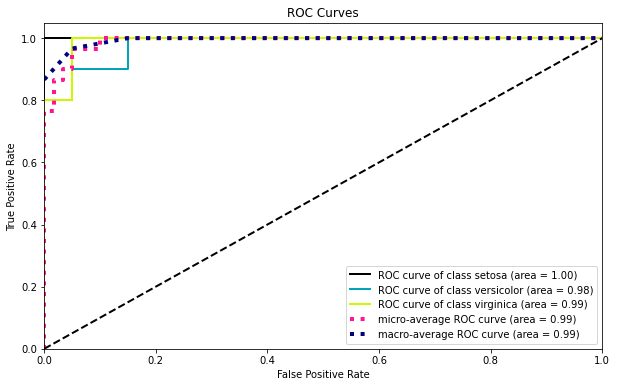

In [68]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, y_probas,figsize=(10,6));

### Pros and Cons of Logistic Regression & Multinomial Regression Classification

The Pros are:

* Interpretable
* Relatively few parameters (d + 1)
* Computationally efficient to estimate parameters
* Multiclass
* Forms foundation of other methods

The Cons:

* Not as accurate as modern methods (but sometimes it is)


### Generalized Linear Model (GLM)
 
#### Linear regression assumes:  

1) The response in normally distributed    
2) The relationship of the response to the independent variables is linear.

A **Generalized Linear Model(GLM)** relaxes these assumptions

A GLM has three components:
1) A distribution from the exponential family (e.g. Normal, Binomial, Poisson, Gamma,etc.).  
2) A Linear Predictor $\beta^T X$  
3) A link function f such that E(Y|X) = $f^{-1}(\beta^T X)$, $f^{-1}$ is called the inverse link function.  

In Logistic regression (a Classification Learning Model): 

1) The response (dependent variable) is modeled as a binomial(1,p) instead of a normal (assumption 1)  
2) The relationship is non-linear (assumption 2). The features (independent variables) are transformed using the logistic function(called the inverse link function).

You often see the parameter transformed using the logit (called the link function) instead of the features being transformed.

Linear regression is a GLM with the inverse link (or link) function being the identity function and the distribution being the Normal.
    
#### There are other GLMs, the most popular are:

* Poisson with link function = log (inverse link = exponential) for counts in fixed amount of time or space
* Gamma with link =  inverse (1/mu) for exponential response data

